In [2]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff
import Convex as cvx
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
import MeshCat as mc
using MeshCat

  Activating environment at `C:\Users\ameys\Desktop\Spring '24\16-745_OptimalControlAndRL\16-745_Flying_Acrobot\Project.toml`
Precompiling project...
  ✓ NBInclude
  ✓ InlineStrings
  ✓ StringManipulation
  ✓ WeakRefStrings
  ✓ CSV
  ✓ PrettyTables
  ✓ DataFrames
  7 dependencies successfully precompiled in 118 seconds (206 already precompiled)


In [3]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","cartpole_animation.jl"))

animate_cartpole (generic function with 1 method)

In [219]:
#copied from RobotZoo src
function swinging_dynamics(params, x, u)
    g = 9.81
    m1,m2 = [1.,1.]
    l1,l2 = [1.,1.]
    J1,J2 = [1.,1.]
    θ1,    θ2    = x[3], x[4]
    θ1dot, θ2dot = x[7], x[8]
    s1,c1 = sincos(θ1)
    s2,c2 = sincos(θ2)
    c12 = cos(θ1 + θ2)

    # mass matrix
    m11 = m1*l1^2 + J1 + m2*(l1^2 + l2^2 + 2*l1*l2*c2) + J2
    m12 = m2*(l2^2 + l1*l2*c2 + J2)
    m22 = l2^2*m2 + J2
    M = [m11 m12; m12 m22]

    # bias term
    tmp = l1*l2*m2*s2
    b1 = -(2 * θ1dot * θ2dot + θ2dot^2)*tmp
    b2 = tmp * θ1dot^2
    B = [b1, b2]

    # friction
    c = 1.0
    C = [c*θ1dot, c*θ2dot]

    # gravity term
    g1 = ((m1 + m2)*l2*c1 + m2*l2*c12) * g
    g2 = m2*l2*c12*g
    G = [g1, g2]

    # equations of motion
    τ = [0, u[1]]
    θddot = M\(τ - B - G - C)
    return [0, 0, θ1dot, θ2dot, 0, 0, θddot[1], θddot[2]]
end


function f(params, q)
    #= 
    this function returns a new state vector [x1, y1, x2, y2, θ1, θ2], good for calculating M(q)
    x1, y1 = coordinates of C.O.M. of link 1
    x2, y2 = coordinates of C.O.M. of link 2
    θ1, θ2 = angle between axis of link and x-axis for links 1 and 2
    =#
    l1, l2 = params.l1, params.l2
    x, y, θ1, θ2 = q[1], q[2], q[3], q[4]
    s1,c1 = sincos(θ1)
    s2,c2 = sincos(θ2)
    s12, c12 = sincos(θ1 + θ2)
    return [x + l1/2*c1,  y + l1/2*s1, x + l1*c1 + l2/2*c12, y + l1*s1 + l2/2*s12, θ1, θ1+θ2] 
end

function Mq(params, q)
    # returns the M(q) matrix used for Euler Lagrange equation
    m1,m2,I1,I2 = params.m1,params.m2,params.I1,params.I2
    M = diagm([m1,m1,m2,m2,I1,I2])
    δfδq = ForwardDiff.jacobian(dq -> f(params, dq), q)
    Mq = δfδq'*M*δfδq
    return Mq
end

function Mqq̇(params, q, q̇)
    # returns the M(q) matrix used for Euler Lagrange equation
    m1,m2,I1,I2 = params.m1,params.m2,params.I1,params.I2
    M = diagm([m1,m1,m2,m2,I1,I2])
    δfδq = ForwardDiff.jacobian(dq -> f(params, dq), q)
    Mq = δfδq'*M*δfδq
    return Mq*q̇
end

function V(params, q)
    # returns the P.E. of the two-link system, used for calculting the B term in Euler Lagrange equation
    g = 9.81
    m1,m2,l1,l2 = params.m1,params.m2,params.l1, params.l2
    x, y, θ1, θ2 = q[1], q[2], q[3], q[4]
    s1,c1 = sincos(θ1)
    s2,c2 = sincos(θ2)
    s12, c12 = sincos(θ1 + θ2)
    V = m1*g*(y + l1/2*s1) + m2*g*(y + l1*s1 + l2/2*s12)
    return V
end

function flight_dynamics(params, x, u)
    #=
    dynamics of the two-link system while air-borne
    calculates qddot using Euler Lagrange equation
    returns ẋ
    =#
    m1, m2, l1, l2, I1, I2 = params.m1, params.m2, params.l1, params.l2, params.I1, params.I2
    g = 9.8
    nx = params.nx
    q = [x[i] for i = 1:4]
    q̇ = [x[i] for i = 5:8]
    
    # mass matrix and its derivative wrt q
    M_q = Mq(params, q)
    δMqδq = ForwardDiff.jacobian(dq -> vec(Mq(params, dq)), q)
    
    # N, C, τ terms
    N = ForwardDiff.gradient(dq -> V(params, dq), q)
    C = ForwardDiff.jacobian(dq -> Mqq̇(params, dq, q̇), q)*q̇ - 1/2*(kron(q̇', I(4))*δMqδq*q̇)
    #C = 1/2*(kron(q̇', I(4))*δMqδq*q̇)
    τ = [u[2], u[3], 0, u[1]]

    M = diagm([m1,m1,m2,m2,I1,I2])
    δfδq = ForwardDiff.jacobian(dq -> f(params, dq), q)
    @show KE = 0.5*(δfδq*q̇)'*M*(δfδq*q̇)
    @show PE = V(params, q)
    @show TE = PE + KE
    
    #equations of motion
    qddot = M_q \ (τ - N - C)
    @show qddot
    return [q̇; qddot]
end

#=function flight_dynamics(params, x, u)
    #=
    dynamics of the two-link system while air-borne
    calculates qddot using Euler Lagrange equation
    returns ẋ
    =#
    nx = params.nx
    q = [x[i] for i = 1:4]
    q̇ = [x[i] for i = 5:8]
    
    # mass matrix and its derivative wrt q
    M_q = Mq(params, q)
    δMqδq = ForwardDiff.jacobian(dq -> vec(Mq(params, dq)), q)

    # N, C, τ terms
    N = ForwardDiff.gradient(dq -> V(params, dq), q)
    #size(kron(q̇', I(4)))
    #size(δMqδq)
    C = 1/2*(kron(q̇', I(4))*δMqδq*q̇)
    τ = [0, 0, 0, u[1]]

    #equations of motion
    qddot = M_q \ (τ - N - C)
    return [q̇; qddot]
end=#

function hermite_simpson(params::NamedTuple, dynamics::Function, x1::Vector, x2::Vector, u, dt::Real)::Vector
    # TODO: input hermite simpson implicit integrator residual 
    x_k_half = 0.5*(x1+x2) + (dt/8)*(dynamics(params, x1, u) - dynamics(params, x2, u))
    return x1 + (dt/6)*(dynamics(params, x1, u) + 4*dynamics(params, x_k_half, u) + 
        dynamics(params, x2, u)) - x2
end

hermite_simpson (generic function with 1 method)

In [5]:
function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + (N) * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end

function flight_cost(params::NamedTuple, Z::Vector)::Real
    idx, N, xg, N1 = params.idx, params.N, params.xg, params.N1
    Q, R, Qf = params.Q, params.R, params.Qf
    
    # TODO: input cartpole LQR cost 
    
    J = 0 
    for i = 1:(N1-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]][1]
        J += 1/2*(ui'*R*ui) + 1/2*(xi-xg)'*Q*(xi-xg)
    end

    # dont forget terminal cost
    # xn = Z[idx.x[N]]
    # J += 1/2*(xn - xg)'*Qf*(xn - xg)    
    
    return J 
end

function flight_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt, N1 = params.idx, params.N, params.dt, params.N1
    l1, l2 = params.l1, params.l2
    # TODO: create dynamics constraints using hermite simpson 
    
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), idx.nc)
    
    for i = 1:N1-1
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
        xip1 = Z[idx.x[i+1]]
        
        # TODO: hermite simpson 
        c[idx.c[i]] = hermite_simpson(params, flight_dynamics, xi, xip1, ui, dt)
    end
        
    return c 
end

function flight_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, N1, idx, xic, xg = params.N, params.N1, params.idx, params.xic, params.xg 
    
    # TODO: return all of the equality constraints
    #bar constraints for the first N time steps
    bar_constraints = [[Z[idx.x[i]][1], Z[idx.x[i]][2]] for i = 1:N] #, Z[idx.x[i]][5], Z[idx.x[i]][6]
    force_constraints = [[Z[idx.u[i]][2], Z[idx.u[i]][3]] for i = N+1:N1-1]
    bar_constraints = vcat(bar_constraints...)
    force_constraints = vcat(force_constraints...)
    
    equality_constraints = [Z[idx.x[1]] - xic;
        bar_constraints;
        force_constraints;
        [Z[idx.x[N1]][1] - 2, Z[idx.x[N1]][1] - 0];
        flight_dynamics_constraints(params, Z)]
    
    return equality_constraints # 10 is an arbitrary number 
end

flight_equality_constraint (generic function with 1 method)

In [6]:
function swing_cost(params::NamedTuple, Z::Vector)::Real
    idx, N, xg, N1 = params.idx, params.N, params.xg, params.N1
    Q, R, Qf = params.Q, params.R, params.Qf
    
    # TODO: input cartpole LQR cost 
    
    J = 0 
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]][1]
        J += 1/2*(ui'*R*ui) + 1/2*(xi-xg)'*Q*(xi-xg)
    end

    # dont forget terminal cost
    xn = Z[idx.x[N]]
    J += 1/2*(xn - xg)'*Qf*(xn - xg)    
    
    return J 
end

function swing_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt, N1 = params.idx, params.N, params.dt, params.N1
    l1, l2 = params.l1, params.l2
    # TODO: create dynamics constraints using hermite simpson 
    
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), idx.nc)
    
    for i = 1:N-1
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        
        # TODO: hermite simpson 
        c[idx.c[i]] = hermite_simpson(params, flight_dynamics, xi, xip1, ui, dt)
    end
        
    return c 
end

function swing_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, N1, idx, xic, xg = params.N, params.N1, params.idx, params.xic, params.xg 
    
    # TODO: return all of the equality constraints
    #bar constraints for the first N time steps
    bar_constraints = [[Z[idx.x[i]][1], Z[idx.x[i]][2]] for i = 2:N] #, Z[idx.x[i]][5], Z[idx.x[i]][6]
    #force_constraints = [[Z[idx.u[i]][2], Z[idx.u[i]][3]] for i = N+1:N1-1]
    bar_constraints = vcat(bar_constraints...)
    #force_constraints = vcat(force_constraints...)
    
    equality_constraints = [Z[idx.x[1]] - xic;
        bar_constraints;
        Z[idx.x[N]][3:4] - xg[3:4];
        swing_dynamics_constraints(params, Z)]
    
    return equality_constraints # 10 is an arbitrary number 
end

swing_equality_constraint (generic function with 1 method)

In [7]:
function solve_flight(X,U, ;verbose = true)
    d = 2 # distance between bars
    v = (d*9.81/(2*sin(pi/3)*cos(pi/3)))^0.5
    t = d/(v*cos(pi/3))
    
    nx = 8
    nu = 3
    dt = 0.05
    tf = 2.8
    t_vec = 0:dt:tf 
    N = length(0:dt:tf-1)
    N1 = length(t_vec)

    #LQR cost
    Q = Diagonal([1.0*ones(2); 0*ones(6)]);
    R = 0.1;
    Qf = Array(10*I(nx));

    # indexing 
    idx = create_idx(nx,nu,N1)
    idx1 = create_idx(nx,nu,N)
    # initial and goal states 
    xic = [0, 0, -pi/2, 0, 0, 0, 0, 0]
    xg = [2, 0, -pi/3, pi/3, 0, 0, 0, 0]

    #load everything useful into params
    params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, N1 = N1, idx = idx, nx = nx, m1 = 1, m2 = 1, I1 = 1, I2 = 1, l1 = 1, l2 = 1)

    # TODO: primal bounds 
    x_l = -Inf*ones(idx.nz)
    x_u = Inf*ones(idx.nz)
    
    #=for i = 1:N1-1
        x_l[idx.x[i]][2] = 0
        x_u[idx.x[i]][2] = 4
    end=#
    
    # inequality constraint bounds (this is what we do when we have no inequality constraints)  
    c_l = zeros(0)
    c_u = zeros(0)
    function inequality_constraint(params, Z)
        return zeros(eltype(Z), 0)
    end


    # initial guess 
    z0 = 0.1*randn(idx.nz)
    for i = 1:N
        z0[idx.x[i]] = X[i]
        z0[idx.u[i]] = U[i]
    end
    @show z0
    
    diff_type = :auto

    Z = fmincon(flight_cost, flight_equality_constraint, inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-3, c_tol = 1e-3, max_iters = 10_000, verbose = verbose)
    
    # pull the X and U solutions out of Z 
    X = [Z[idx.x[i]] for i = 1:N1]
    U = [Z[idx.u[i]] for i = 1:(N1-1)]
    
    return X, U, t_vec, params 
end

solve_flight (generic function with 1 method)

In [23]:
function solve_swing(;verbose = true)
    nx = 8
    nu = 3
    dt = 0.05
    tf = 3
    t_vec = 0:dt:tf 
    N = length(0:dt:tf)
    N1 = length(0:dt:tf)

    #LQR cost
    Q = Diagonal([0*ones(2); 1*ones(2); 0*ones(2); 0.1*ones(2)]);
    R = 0.1;
    Qf = Array(10*I(nx));

    # indexing 
    idx = create_idx(nx,nu,N)
    
    # initial and goal states 
    xic = [0, 0, -pi/2, 0, 0, 0, 0, 0]
    xg = [0, 0, pi/2, 0, 0, 0, 0, 0]

    #load everything useful into params
    params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, N1 = N1, idx = idx, nx = nx, m1 = 1, m2 = 1, I1 = 1, I2 = 1, l1 = 1, l2 = 1)

    # TODO: primal bounds 
    x_l = -Inf*ones(idx.nz)
    x_u = Inf*ones(idx.nz)
    
    #=for i = 1:N-1
        x_l[idx.u[i]][1] = -1000
        x_u[idx.u[i]][2] = 1000
    end=#
    
    # inequality constraint bounds (this is what we do when we have no inequality constraints)  
    c_l = zeros(0)
    c_u = zeros(0)
    function inequality_constraint(params, Z)
        return zeros(eltype(Z), 0)
    end


    # initial guess 
    z0 = 0.1*randn(idx.nz)

    diff_type = :auto

    Z = fmincon(swing_cost, swing_equality_constraint, inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-3, c_tol = 1e-3, max_iters = 10_000, verbose = verbose)
    
    # pull the X and U solutions out of Z 
    X = [Z[idx.x[i]] for i = 1:N]
    U = [Z[idx.u[i]] for i = 1:(N-1)]
    
    return X, U, t_vec, params 
end

solve_swing (generic function with 1 method)

In [207]:
Unew = []
for i = 1:80
    append!(Unew, [[0, 0, 10]])
end
Unew

80-element Vector{Any}:
 [0, 0, 10]
 [0, 0, 10]
 [0, 0, 10]
 [0, 0, 10]
 [0, 0, 10]
 [0, 0, 10]
 [0, 0, 10]
 [0, 0, 10]
 [0, 0, 10]
 [0, 0, 10]
 [0, 0, 10]
 [0, 0, 10]
 [0, 0, 10]
 ⋮
 [0, 0, 10]
 [0, 0, 10]
 [0, 0, 10]
 [0, 0, 10]
 [0, 0, 10]
 [0, 0, 10]
 [0, 0, 10]
 [0, 0, 10]
 [0, 0, 10]
 [0, 0, 10]
 [0, 0, 10]
 [0, 0, 10]

In [221]:
function rk4(params::NamedTuple, dynamics::Function, x::Vector, u, dt::Float64)
    # vanilla RK4
    k1 = dt*dynamics(params, x, u)
    k2 = dt*dynamics(params, x + k1/2, u)
    k3 = dt*dynamics(params, x + k2/2, u)
    k4 = dt*dynamics(params, x + k3, u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

nx = 8
nu = 3
dt = 0.05
tf = 4
t_vec = 0:dt:tf 
N = length(0:dt:tf)
N1 = length(0:dt:tf)

#LQR cost
Q = Diagonal([0*ones(2); 1*ones(2); 0*ones(2); 0.1*ones(2)]);
R = 0.1;
Qf = Array(10*I(nx));

# indexing 
idx = create_idx(nx,nu,N)

# initial and goal states 
xic = [0,0,0,0,5,5,0,0]
xg = [0, 0, pi/2, 0, 0, 0, 0, 0]

#load everything useful into params
params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, N1 = N1, idx = idx, nx = nx, m1 = 1, m2 = 1, I1 = 1, I2 = 1, l1 = 1, l2 = 1)


Xstart = [0,0,0,0,5,5,0,0]
Xnew = [zeros(8) for i = 1:101]
Xnew[1] = Xstart

for i = 1:80
    Xnew[i+1] = rk4(params, flight_dynamics, Xnew[i], Unew[i], dt)
end

KE = 0.5 * (δfδq * q̇)' * M * (δfδq * q̇) = 50.0
PE = V(params, q) = 0.0
TE = PE + KE = 50.0
qddot = [0.0, 0.4399999999999995, -6.5, 5.0]
KE = 0.5 * (δfδq * q̇)' * M * (δfδq * q̇) = 48.828366312499995
PE = V(params, q) = 2.4525
TE = PE + KE = 51.280866312499995
qddot = [0.010078125000000002, 0.8431249999999997, -7.04375, 5.5625]
KE = 0.5 * (δfδq * q̇)' * M * (δfδq * q̇) = 48.82806727080539
PE = V(params, q) = 2.393517540106523
TE = PE + KE = 51.221584810911914
qddot = [0.03373948039075736, 0.8743053823080622, -7.087241123365174, 5.6113772617215565]
KE = 0.5 * (δfδq * q̇)' * M * (δfδq * q̇) = 47.722989856570415
PE = V(params, q) = 4.787036429165016
TE = PE + KE = 52.51002628573543
qddot = [0.09913002071828352, 1.3093654251847386, -7.676275263572898, 6.225080786094762]
KE = 0.5 * (δfδq * q̇)' * M * (δfδq * q̇) = 47.72197737489824
PE = V(params, q) = 4.787035565711548
TE = PE + KE = 52.509012940609786
qddot = [0.09773150991927024, 1.3078558838316958, -7.67412348343298, 6.22259953131409]
K

In [10]:
#@testset "cartpole swingup" begin 

X1, U1, t_vec = solve_flight(X,U, verbose=true)

LoadError: UndefVarError: X not defined

In [24]:
#@testset "cartpole swingup" begin 

X, U, t_vec = solve_swing(verbose=true)

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   407480
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      668
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      610
Total number of inequality constraints.......

([[0.0, 0.0, -1.5707963267948966, -1.0657757435837452e-26, 6.339483388644729e-27, 0.0, 0.0, 0.0], [0.0, 0.0, -1.578900302626572, 0.03781246132090495, 0.00027484955671398445, -0.0035881868447961594, -0.3240910867906937, 1.5113727865241986], [0.0, 0.0, -1.5997369457952655, 0.13503127525603473, 0.000651245279286158, -0.001604560985113885, -0.5090268343075988, 2.374101847747424], [0.0, 0.0, -1.6263482007872219, 0.2593187535164818, 0.0005105477368429957, 0.00012991638239008893, -0.5549777791040034, 2.5931759508177517], [0.0, 0.0, -1.6520721659612516, 0.3795238902043714, 5.6007355167123875e-5, 0.0029765671938040594, -0.47395871073673473, 2.21164343432955], [0.0, 0.0, -1.6707757707984883, 0.4659157469485205, -0.00039811474283770875, 0.002225172652231888, -0.27471231719042555, 1.2425633927319486], [0.0, -1.523222019789313e-27, -1.6759274700316147, 0.48562091927923234, 7.98535735644463e-5, -0.00024684209209469373, 0.06842147361691203, -0.4543976031364083], [0.0, 0.0, -1.6580150297271021, 0.3921

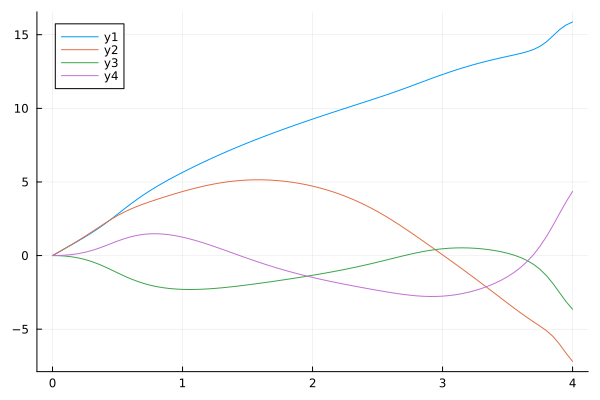

In [216]:
# plot x and y coordinates against time
Xm = [[Xnew[i][1], Xnew[i][2], Xnew[i][3], Xnew[i][4]] for i = 1:length(t_vec)]
Xm = hcat(Xm...)
plot(t_vec,Xm')

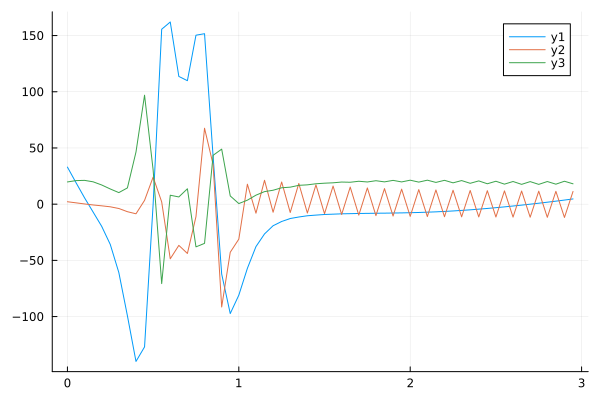

In [63]:
#plot of forces and torque vs time during the swing phase
Xm = [[U[i][1],U[i][2], U[i][3]] for i = 1:length(t_vec)-1]
Xm = hcat(Xm...)
plot(0:0.05:2.95,Xm')

In [203]:
# Acrobot (doublependulum)
using Colors
function build_acrobot!(vis, color=colorant"blue", thick=0.05)
    l1,l2 = [1.,1.]
    hinge = MeshCat.Cylinder(MeshCat.Point3f(-0.05,0,0), MeshCat.Point3f(0.05,0,0), 0.05f0)
    dim1  = MeshCat.Vec(thick, thick, l1)
    link1 = MeshCat.HyperRectangle(MeshCat.Vec(-thick/2,-thick/2,0),dim1)
    dim2  = MeshCat.Vec(thick, thick, l2)
    link2 = MeshCat.HyperRectangle(MeshCat.Vec(-thick/2,-thick/2,0),dim2)
    mat1 = MeshPhongMaterial(color=colorant"grey")
    mat2 = MeshPhongMaterial(color=color)
    setobject!(vis["base"], hinge, mat1)
    setobject!(vis["link1"], link1, mat2) 
    setobject!(vis["link1","joint"], hinge, mat1) 
    setobject!(vis["link1","link2"], link2, mat2) 
    settransform!(vis["link1","link2"], MeshCat.Translation(0,0,l1))
    settransform!(vis["link1","joint"], MeshCat.Translation(0,0,l1))
end

function RotX(alpha)
    c, s = cos(alpha), sin(alpha)
    [1 0 0; 0 c -s; 0 s  c]
end
#=function update_acro_pose!(vis, x)
    l1, l2 = [1, 1.]
    settransform!(vis["robot","link1"], MeshCat.LinearMap(RotX(x[1]-pi/2)))
    settransform!(vis["robot","link1","link2"], MeshCat.compose(MeshCat.Translation(0,0,l1), MeshCat.LinearMap(RotX(x[2]))))
end=#

#=function update_acro_pose!(vis, y, z, theta1, theta2)
    l1, l2 = [1, 1.]
    
    settransform!(vis["robot","base"], MeshCat.Translation(0.0, y, z))   
    settransform!(vis["robot","link1","link2"], MeshCat.compose(MeshCat.Translation(0,0,l1), MeshCat.LinearMap(RotX(theta2))))
    settransform!(vis["robot","link1"], MeshCat.compose(MeshCat.Translation(0,y,z), MeshCat.LinearMap(RotX(theta1-pi/2))))
end=#
function update_acro_pose!(vis, y, z, theta1, theta2)
    l1, l2 = [1, 1.]
    
    # Update base transformation
    settransform!(vis["robot","base"], MeshCat.Translation(0.0, y, z))
    
    # First link transformation
    settransform!(vis["robot","link1"], MeshCat.compose(MeshCat.Translation(0,y,z), MeshCat.LinearMap(RotX(theta1-pi/2))))

    # Debug print current transformation state
    println("Link1 position: ", MeshCat.Translation(0,y,z))
    println("Link1 rotation: ", MeshCat.LinearMap(RotX(theta1-pi/2)))

    # Second link transformation
    settransform!(vis["robot","link1","link2"], MeshCat.compose(MeshCat.Translation(0,0,l1), MeshCat.LinearMap(RotX(theta2))))
    
    # Debug print current transformation state
    println("Link2 translation: ", MeshCat.Translation(0,0,l1))
    println("Link2 rotation: ", MeshCat.LinearMap(RotX(theta2)))
end

update_acro_pose! (generic function with 1 method)

In [205]:
dt = 0.05
N = length(t_vec)
vis = Visualizer()
build_acrobot!(vis["robot"])
anim = MeshCat.Animation(floor(Int, 1 / dt))

for k = 1:N
    MeshCat.atframe(anim, k) do
        #update_acro_pose!(vis, X[k][3:4])
        update_acro_pose!(vis, Xnew[k][1], Xnew[k][2], Xnew[k][3], Xnew[k][4])
    end
end
MeshCat.setanimation!(vis, anim)
render(vis)

Link1 position: Translation(0.0, 0.0, 0.0)
Link1 rotation: LinearMap([1.0 0.0 0.0; 0.0 6.123233995736766e-17 1.0; 0.0 -1.0 6.123233995736766e-17])
Link2 translation: Translation(0.0, 0.0, 1.0)
Link2 rotation: LinearMap([1.0 0.0 0.0; 0.0 1.0 -0.0; 0.0 0.0 1.0])
Link1 position: Translation(0.0, 0.2500182573355795, 0.2508989293259617)
Link1 rotation: LinearMap([1.0 0.0 0.0; 0.0 -0.008596140431211178 0.9999630525022847; 0.0 -0.9999630525022847 -0.008596140431211178])
Link2 translation: Translation(0.0, 0.0, 1.0)
Link2 rotation: LinearMap([1.0 0.0 0.0; 0.0 0.9999772922469063 -0.006739064515582951; 0.0 0.006739064515582951 0.9999772922469063])
Link1 position: Translation(0.0, 0.5003380674151413, 0.5050862879318857)
Link1 rotation: LinearMap([1.0 0.0 0.0; 0.0 -0.03639874295496695 0.9993373462006202; 0.0 -0.9993373462006202 -0.03639874295496695])
Link2 translation: Translation(0.0, 0.0, 1.0)
Link2 rotation: LinearMap([1.0 0.0 0.0; 0.0 0.9995775660280695 -0.029063542340884475; 0.0 0.02906354234

[ Info: Listening on: 127.0.0.1:8726, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8726


Translation(0.0, 0.0, 1.0)
Link2 rotation: LinearMap([1.0 0.0 0.0; 0.0 0.4057823998776058 0.9139697171950343; 0.0 -0.9139697171950343 0.4057823998776058])
Link1 position: Translation(0.0, 8.965864375326868, 4.898395182988985)
Link1 rotation: LinearMap([1.0 0.0 0.0; 0.0 -0.996121691457728 0.0879862251002674; 0.0 -0.0879862251002674 -0.996121691457728])
Link2 translation: Translation(0.0, 0.0, 1.0)
Link2 rotation: LinearMap([1.0 0.0 0.0; 0.0 0.29754875437642164 0.9547066244501711; 0.0 -0.9547066244501711 0.29754875437642164])
Link1 position: Translation(0.0, 9.118580886506932, 4.813918110881654)
Link1 rotation: LinearMap([1.0 0.0 0.0; 0.0 -0.9873854115514672 0.15833524261938572; 0.0 -0.15833524261938572 -0.9873854115514672])
Link2 translation: Translation(0.0, 0.0, 1.0)
Link2 rotation: LinearMap([1.0 0.0 0.0; 0.0 0.19046234097115042 0.981694502720571; 0.0 -0.981694502720571 0.19046234097115042])
Link1 position: Translation(0.0, 9.269358530163409, 4.716826165019877)
Link1 rotation: Linear

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x62, 0x61, 0x73, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "link1" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x31], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("joint" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "link2" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x32], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8726))

In [17]:
Pkg.add("DataFrames")
Pkg.add("CSV")

    Updating registry at `C:\Users\ameys\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `C:\Users\ameys\Desktop\Spring '24\16-745_OptimalControlAndRL\16-745_Flying_Acrobot\Project.toml`
  No Changes to `C:\Users\ameys\Desktop\Spring '24\16-745_OptimalControlAndRL\16-745_Flying_Acrobot\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ameys\Desktop\Spring '24\16-745_OptimalControlAndRL\16-745_Flying_Acrobot\Project.toml`
  No Changes to `C:\Users\ameys\Desktop\Spring '24\16-745_OptimalControlAndRL\16-745_Flying_Acrobot\Manifest.toml`


In [18]:
using DataFrames
using CSV

df = DataFrame(Array=[X;111;U])
CSV.write("Z.xml", df, format="xml")

"Z.xml"